Z-Score Method

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                precision    recall  f1-score   support

Not a good fit       0.99      1.00      1.00       150
           Fit       1.00      0.98      0.99        43

      accuracy                           0.99       193
     macro avg       1.00      0.99      0.99       193
  weighted avg       0.99      0.99      0.99       193



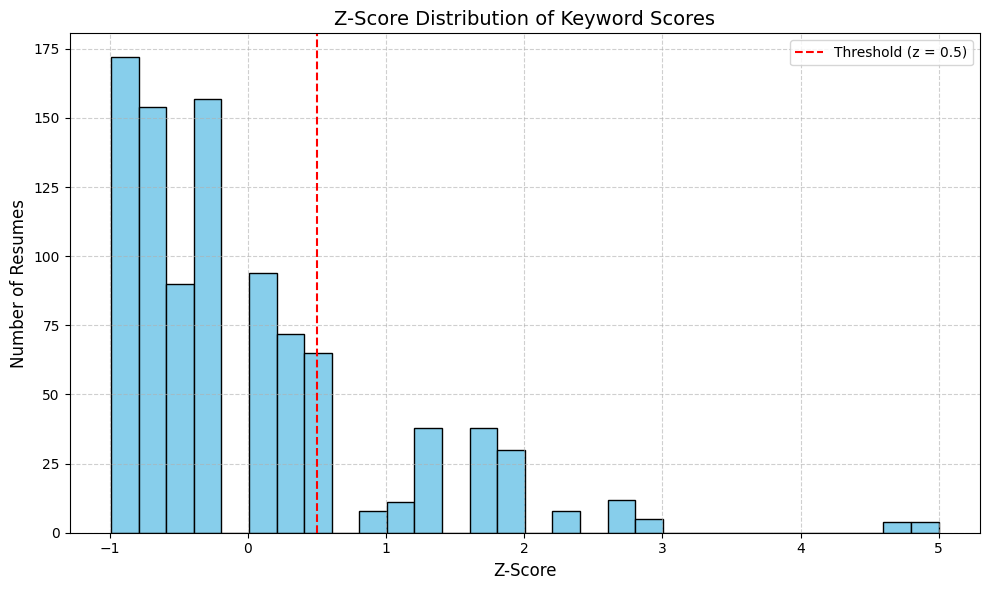

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

nltk.download('stopwords')
from nltk.corpus import stopwords

#Load dataset
df = pd.read_csv('/cleaned_dataset.csv')
df = df[['Category', 'Resume']]

#Clean text func
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)

df['Cleaned_Resume'] = df['Resume'].apply(clean_text)

#Keyword list
keywords = pd.read_csv('/keywords.csv')['Skill'].tolist()

def keyword_score(text):
    return sum([1 for kw in keywords if kw in text])

df['KeywordScore'] = df['Cleaned_Resume'].apply(keyword_score)

# Z-score labeling

mean_score = df['KeywordScore'].mean()
std_score = df['KeywordScore'].std()
df['ZScore'] = (df['KeywordScore'] - mean_score) / std_score
df['Label'] = df['ZScore'].apply(lambda z: 1 if z >= 0.5 else 0)


#Model training
X = df['Cleaned_Resume']
y = df['Label']

vectorizer = CountVectorizer(max_features=1000)
X_vec = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['Not a good fit', 'Fit']))

# Z-Score histogram
plt.figure(figsize=(10, 6))
plt.hist(df['ZScore'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold (z = 0.5)')
plt.title('Z-Score Distribution of Keyword Scores', fontsize=14)
plt.xlabel('Z-Score', fontsize=12)
plt.ylabel('Number of Resumes', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#Test resume decisions outpit
df['Prediction'] = model.predict(vectorizer.transform(df['Cleaned_Resume']))
df['Decision'] = df['Prediction'].apply(lambda x: "Fit – Move forward with interview" if x == 1 else "Not a good fit")

#for i, row in df.iterrows():
    #print(f"Resume #{i+1}: {row['Decision']} (KeywordScore: {row['KeywordScore']})")

Exporting Results into CSV file

In [ ]:
df[['Resume', 'Decision']].to_csv("results_Z-score.csv", index=False)